# Convergence Testing: The Foundation of Reliable DFT Calculations

## Why This Notebook is Critical

**Convergence testing is the single most important step before any DFT property calculation.**

Without proper convergence testing:
- Your total energies are meaningless numbers
- Your lattice constants could be off by several percent
- Your band gaps are unreliable
- Your phonon frequencies may have wrong signs
- Your calculated phase transitions may not exist

### Learning Objectives

1. Understand why convergence testing is non-negotiable
2. Master ecutwfc (wavefunction cutoff) convergence testing
3. Master k-point mesh convergence testing
4. Learn smearing width convergence for metals
5. Perform combined (2D) convergence analysis
6. Understand force and stress convergence requirements
7. Store and reuse converged parameters

---

## 1. Why Convergence Testing is Non-Negotiable

### The Core Concept

A calculation is **converged** when increasing the accuracy parameter (cutoff, k-points, etc.) no longer changes the quantity of interest beyond a specified threshold.

### Key Principles

| Principle | Description |
|-----------|-------------|
| **Variational** | Total energy approaches the true value from above as basis improves |
| **Systematic** | Errors decrease monotonically with increasing accuracy |
| **Property-dependent** | Different properties require different convergence levels |
| **System-specific** | Converged values depend on elements and pseudopotentials |

### Standard Convergence Criteria

| Property | Typical Threshold | Stringent Threshold |
|----------|-------------------|--------------------|
| Total energy | 1 meV/atom | 0.1 meV/atom |
| Forces | 10 meV/Angstrom | 1 meV/Angstrom |
| Stress | 0.5 kbar | 0.1 kbar |
| Lattice constant | 0.01 Angstrom | 0.001 Angstrom |

### The Three Parameters We Must Converge

1. **ecutwfc**: Plane wave kinetic energy cutoff
2. **K-point mesh**: Brillouin zone sampling density
3. **Smearing width** (metals only): Fermi surface broadening

---

## 2. Setup and Helper Functions

First, let's set up our working environment and define all the functions we'll need.

In [1]:
# =============================================================================
# SETUP - Run this cell first (downloads pseudopotentials automatically)
# =============================================================================

import sys
import os
from pathlib import Path
from typing import Any, Dict, Optional

import numpy as np
import matplotlib.pyplot as plt
import json
import time
import re

from ase import Atoms
from ase.build import bulk
from ase.data import atomic_masses, atomic_numbers

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION FOR YOUR MATERIAL <<<
# =============================================================================

MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'
# FUNCTIONAL = 'PBEsol'

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc_sssp, ecutrho_sssp = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)

# Backward-compatibility alias used by some cells below
PSEUDO_DIR = PSEUDO_DIR_FUNC

WORK_DIR = OUTPUT_DIR / '04_convergence'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"CONVERGENCE TESTING SETUP")
print(f"{'='*70}")
print(f"Material:       {MATERIAL} ({STRUCTURE_TYPE})")
print(f"Lattice:        {LATTICE_A} Å")
print(f"Functional:     {FUNCTIONAL}")
print(f"Pseudo dir:     {PSEUDO_DIR_FUNC}")
print(f"SSSP cutoffs:   ecutwfc={ecutwfc_sssp} Ry, ecutrho={ecutrho_sssp} Ry")
print(f"Working dir:    {WORK_DIR}")
print(f"{'='*70}")
print(f"\nPseudopotentials for {FUNCTIONAL}:")
for elem, path in pp_files.items():
    print(f"  {elem}: {path.name}")


# =============================================================================
# Backward-compatible helpers (so older cells still execute)
# =============================================================================

def generate_scf_input(prefix: str, ecutwfc: float, ecutrho: float,
                       kpoints, pseudo_dir,
                       celldm1=None,
                       conv_thr: float = 1.0e-8,
                       degauss: float = 0.01,
                       smearing: str = 'cold') -> str:
    """Generate a QE SCF input file text (QE 6.x compatible)."""

    ecutwfc = float(ecutwfc)
    ecutrho = float(ecutrho)
    conv_thr = float(conv_thr)
    degauss = float(degauss)

    if isinstance(kpoints, (list, tuple)):
        kpoints = tuple(int(k) for k in kpoints)

    pseudo_dir = Path(pseudo_dir)
    pseudo_dir_rel = os.path.relpath(pseudo_dir, WORK_DIR)

    species = sorted(set(atoms.get_chemical_symbols()))

    lines = []
    lines.append("&CONTROL")
    lines.append("   calculation = 'scf'")
    lines.append(f"   prefix = '{prefix}'")
    lines.append("   outdir = './tmp'")
    lines.append(f"   pseudo_dir = '{pseudo_dir_rel}'")
    lines.append("   verbosity = 'high'")
    lines.append("   tprnfor = .true.")
    lines.append("   tstress = .true.")
    lines.append("/")

    lines.append("&SYSTEM")
    lines.append("   ibrav = 0")
    lines.append(f"   nat = {len(atoms)}")
    lines.append(f"   ntyp = {len(species)}")
    lines.append(f"   ecutwfc = {ecutwfc}")
    lines.append(f"   ecutrho = {ecutrho}")
    lines.append("   occupations = 'smearing'")
    lines.append(f"   smearing = '{smearing}'")
    lines.append(f"   degauss = {degauss}")
    lines.append("/")

    lines.append("&ELECTRONS")
    lines.append(f"   conv_thr = {conv_thr}")
    lines.append("/")

    lines.append("ATOMIC_SPECIES")
    for s in species:
        mass = float(atomic_masses[atomic_numbers[s]])
        pp = get_pseudopotential_filename(s, FUNCTIONAL)
        lines.append(f" {s} {mass:.6f} {pp}")

    lines.append("K_POINTS {automatic}")
    lines.append(f" {kpoints[0]} {kpoints[1]} {kpoints[2]} 0 0 0")

    lines.append("CELL_PARAMETERS {angstrom}")
    for v in atoms.get_cell():
        lines.append(f" {v[0]:.12f} {v[1]:.12f} {v[2]:.12f}")

    lines.append("ATOMIC_POSITIONS {angstrom}")
    for s, p in zip(atoms.get_chemical_symbols(), atoms.get_positions()):
        lines.append(f" {s} {p[0]:.10f} {p[1]:.10f} {p[2]:.10f}")

    lines.append("")
    return "\n".join(lines)


def run_calculation(input_file: Path, nprocs: int = None):
    """Backward-compatible wrapper around `run_qe`."""
    return run_qe(Path(input_file), executable='pw.x', nprocs=nprocs or NPROCS, use_mpi=True, timeout=1800)


PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

CONVERGENCE TESTING SETUP
Material:       Si (diamond)
Lattice:        5.43 Å
Functional:     PBE
Pseudo dir:     /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
SSSP cutoffs:   ecutwfc=40 Ry, ecutrho=320 Ry
Working dir:    /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_convergence

Pseudopotentials for PBE:
  Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### 2.1 Input File Generation Function

This function generates SCF input files with configurable parameters.

In [2]:
# =============================================================================
# MINIMAL INPUT FILE GENERATOR USING ASE
# =============================================================================

def create_scf_input(atoms, prefix, ecutwfc, kpts, work_dir):
    """
    Create QE SCF input using ASE.
    """
    input_file = work_dir / f'{prefix}.in'

    pseudopotentials = {}
    for elem in set(atoms.get_chemical_symbols()):
        pseudopotentials[elem] = get_pseudopotential_filename(elem, FUNCTIONAL)

    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(PSEUDO_DIR_FUNC),
            'verbosity': 'high',
            'tprnfor': True,
            'tstress': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * 8,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {
            'conv_thr': 1.0e-8,
        },
    }

    write_espresso_in(input_file, atoms, input_data=input_data,
                      pseudopotentials=pseudopotentials, kpts=kpts)
    return input_file


def parse_energy(output_text):
    """Extract total energy from QE output."""
    for line in output_text.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
            if match:
                return float(match.group(1)) * RY_TO_EV
    return None


print("Input generator and parser functions defined.")

Input generator and parser functions defined.


### 2.2 Output Parsing Function

This function extracts key quantities from pw.x output files.

In [3]:
def parse_output(output_text: str) -> Dict[str, Any]:
    """
    Parse pw.x output to extract key quantities.
    
    Parameters
    ----------
    output_text : str
        Full text content of pw.x output file
    
    Returns
    -------
    dict
        Dictionary containing:
        - converged: bool, whether SCF converged
        - energy_ry: float, total energy in Ry
        - volume_bohr3: float, cell volume in Bohr^3
        - pressure_kbar: float, total pressure in kbar
        - total_force: float, total force magnitude in Ry/Bohr
        - nkpts_irreducible: int, number of irreducible k-points
        - max_force: float, maximum force component
        - forces: list, all atomic forces
        - stress_tensor: np.ndarray, 3x3 stress tensor in kbar
    """
    results = {
        'converged': False,
        'energy_ry': None,
        'volume_bohr3': None,
        'pressure_kbar': None,
        'total_force': None,
        'nkpts_irreducible': None,
        'max_force': None,
        'forces': [],
        'stress_tensor': None,
        'scf_iterations': 0
    }
    
    # Check convergence
    results['converged'] = 'convergence has been achieved' in output_text
    
    # Count SCF iterations
    iteration_matches = re.findall(r'iteration #\s*(\d+)', output_text)
    if iteration_matches:
        results['scf_iterations'] = int(iteration_matches[-1])
    
    lines = output_text.split('\n')
    stress_lines = []
    in_stress_block = False
    
    for i, line in enumerate(lines):
        # Final total energy (marked with !)
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Ry', line)
            if match:
                results['energy_ry'] = float(match.group(1))
        
        # Volume
        if 'unit-cell volume' in line:
            match = re.search(r'=\s+([\d.]+)', line)
            if match:
                results['volume_bohr3'] = float(match.group(1))
        
        # Number of k-points
        if 'number of k points' in line:
            match = re.search(r'=\s+(\d+)', line)
            if match:
                results['nkpts_irreducible'] = int(match.group(1))
        
        # Pressure from stress tensor line
        if 'total   stress' in line and 'P=' in line:
            match = re.search(r'P=\s*([\d.E+-]+)', line)
            if match:
                results['pressure_kbar'] = float(match.group(1))
            in_stress_block = True
            stress_lines = []
            continue
        
        # Capture stress tensor lines (3 lines after the header)
        if in_stress_block and len(stress_lines) < 3:
            stripped = line.strip()
            if stripped:
                stress_lines.append(stripped)
            if len(stress_lines) == 3:
                in_stress_block = False
                # Parse stress tensor (kbar values are in columns 4-6)
                stress_tensor = np.zeros((3, 3))
                for j, sline in enumerate(stress_lines):
                    parts = sline.split()
                    if len(parts) >= 6:
                        stress_tensor[j] = [float(parts[3]), float(parts[4]), float(parts[5])]
                results['stress_tensor'] = stress_tensor
        
        # Total force
        if 'Total force' in line:
            match = re.search(r'Total force\s*=\s*([\d.]+)', line)
            if match:
                results['total_force'] = float(match.group(1))
        
        # Individual atomic forces
        if 'atom' in line and 'force =' in line:
            match = re.search(r'force\s*=\s*([\d.E+-]+)\s+([\d.E+-]+)\s+([\d.E+-]+)', line)
            if match:
                fx, fy, fz = float(match.group(1)), float(match.group(2)), float(match.group(3))
                results['forces'].append([fx, fy, fz])
    
    # Calculate maximum force if forces were found
    if results['forces']:
        forces_array = np.array(results['forces'])
        force_magnitudes = np.sqrt(np.sum(forces_array**2, axis=1))
        results['max_force'] = float(np.max(force_magnitudes))
    
    return results


# Test with sample output
SAMPLE_OUTPUT = """
     Program PWSCF v.7.0 starts on  1Jan2024 at 12:00:00

     unit-cell volume          =     270.0114 (a.u.)^3
     number of k points=    10

     iteration #  1     ecut=    40.00 Ry
     iteration #  2     ecut=    40.00 Ry
     iteration #  3     ecut=    40.00 Ry

     convergence has been achieved in   3 iterations

     Forces acting on atoms (cartesian axes, Ry/au):

     atom    1 type  1   force =     0.00001234    0.00000000    0.00000000
     atom    2 type  1   force =    -0.00001234    0.00000000    0.00000000

     Total force =     0.000017     Total SCF correction =     0.000000

     total   stress  (Ry/bohr**3)                   (kbar)     P=       -5.50
        -0.00003740   0.00000000   0.00000000           -5.50        0.00        0.00
         0.00000000  -0.00003740   0.00000000            0.00       -5.50        0.00
         0.00000000   0.00000000  -0.00003740            0.00        0.00       -5.50

!    total energy              =     -15.84550000 Ry
"""

parsed = parse_output(SAMPLE_OUTPUT)
print("Parsed Output Results:")
print("=" * 50)
for key, value in parsed.items():
    if key == 'stress_tensor' and value is not None:
        print(f"{key}:")
        print(value)
    else:
        print(f"{key}: {value}")

Parsed Output Results:
converged: True
energy_ry: -15.8455
volume_bohr3: 270.0114
pressure_kbar: -5.5
total_force: 1.7e-05
nkpts_irreducible: 10
max_force: 1.234e-05
forces: [[1.234e-05, 0.0, 0.0], [-1.234e-05, 0.0, 0.0]]
stress_tensor:
[[-5.5  0.   0. ]
 [ 0.  -5.5  0. ]
 [ 0.   0.  -5.5]]
scf_iterations: 3


### 2.3 Calculation Runner Function

This function executes pw.x and handles output.

In [4]:
# =============================================================================
# ECUTWFC CONVERGENCE TEST
# =============================================================================
# This runs real QE calculations to find the converged wavefunction cutoff.
# Convergence criterion: energy change < 1 meV/atom between steps.
# =============================================================================

def run_ecutwfc_convergence(atoms, kpts=(8,8,8), ecutwfc_values=None):
    """
    Run ecutwfc convergence test.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure to test
    kpts : tuple
        K-point mesh (fixed during test)
    ecutwfc_values : list
        Cutoff values to test (Ry)
    
    Returns
    -------
    dict : Convergence results
    """
    if ecutwfc_values is None:
        # Default: test from 20 to 100 Ry in steps of 10
        ecutwfc_values = [20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    n_atoms = len(atoms)
    energies = []
    
    print(f"\n{'='*60}")
    print(f"ECUTWFC CONVERGENCE TEST")
    print(f"K-points: {kpts}, Atoms: {n_atoms}")
    print(f"{'='*60}")
    print(f"{'ecutwfc (Ry)':<15} {'E (eV/atom)':<15} {'ΔE (meV/atom)':<15} {'Status'}")
    print(f"{'-'*60}")
    
    for ecutwfc in ecutwfc_values:
        prefix = f'conv_ecut_{int(ecutwfc)}'
        input_file = create_scf_input(atoms, prefix, ecutwfc, kpts, WORK_DIR)
        output, _, converged = run_qe(input_file, nprocs=NPROCS)
        
        energy = parse_energy(output)
        if energy is not None:
            e_per_atom = energy / n_atoms
            energies.append((ecutwfc, e_per_atom))
            
            if len(energies) > 1:
                delta = (e_per_atom - energies[-2][1]) * 1000  # meV
                status = "✓ converged" if abs(delta) < 1.0 else ""
            else:
                delta = float('nan')
                status = ""
            
            print(f"{ecutwfc:<15.0f} {e_per_atom:<15.6f} {delta:<15.3f} {status}")
        else:
            print(f"{ecutwfc:<15.0f} {'FAILED':<15} {'-':<15}")
    
    print(f"{'='*60}")
    
    # Find converged value
    for i in range(1, len(energies)):
        delta = abs(energies[i][1] - energies[i-1][1]) * 1000
        if delta < 1.0:
            print(f"\n✓ CONVERGED at ecutwfc = {energies[i][0]} Ry (ΔE < 1 meV/atom)")
            break
    
    return {
        'ecutwfc': [e[0] for e in energies],
        'energy_per_atom': [e[1] for e in energies],
    }


# To run the test (uncomment):
# results = run_ecutwfc_convergence(atoms)

print("Convergence test function defined.")
print("To run: results = run_ecutwfc_convergence(atoms)")

Convergence test function defined.
To run: results = run_ecutwfc_convergence(atoms)


### 2.4 Convergence Analysis Function

This function analyzes convergence of calculated values.

In [5]:
def analyze_convergence(
    parameter_values: np.ndarray,
    energies: np.ndarray,
    threshold_mev_per_atom: float = 1.0,
    n_atoms: int = 2,
    reference_idx: int = -1
) -> Dict[str, Any]:
    """
    Analyze convergence of total energy with respect to a parameter.
    
    Parameters
    ----------
    parameter_values : np.ndarray
        Array of parameter values tested
    energies : np.ndarray
        Corresponding total energies in Ry
    threshold_mev_per_atom : float
        Convergence threshold in meV/atom
    n_atoms : int
        Number of atoms in unit cell
    reference_idx : int
        Index of reference calculation (default: -1, most accurate)
    
    Returns
    -------
    dict
        Dictionary containing:
        - delta_E_meV_per_atom: energy differences
        - converged_value: first converged parameter value
        - converged_index: index of converged value
        - reference_energy: reference energy in Ry
    """
    parameter_values = np.array(parameter_values)
    energies = np.array(energies)
    
    reference_energy = energies[reference_idx]
    
    # Calculate energy differences in meV/atom
    delta_E = (energies - reference_energy) * RY_TO_MEV / n_atoms
    
    # Find first converged point
    converged_value = None
    converged_index = None
    
    for i, de in enumerate(delta_E):
        if abs(de) <= threshold_mev_per_atom:
            converged_value = parameter_values[i]
            converged_index = i
            break
    
    return {
        'delta_E_meV_per_atom': delta_E,
        'converged_value': converged_value,
        'converged_index': converged_index,
        'reference_energy': reference_energy,
        'threshold_mev_per_atom': threshold_mev_per_atom
    }


# Test with sample data
test_params = np.array([20, 30, 40, 50, 60, 70, 80])
test_energies = np.array([-15.80, -15.84, -15.845, -15.8455, -15.8456, -15.8456, -15.8456])

conv_analysis = analyze_convergence(test_params, test_energies, threshold_mev_per_atom=1.0)

print("Convergence Analysis Test:")
print("=" * 50)
print(f"Reference energy: {conv_analysis['reference_energy']:.6f} Ry")
print(f"Threshold: {conv_analysis['threshold_mev_per_atom']} meV/atom")
print(f"Converged at: {conv_analysis['converged_value']} (index {conv_analysis['converged_index']})")
print(f"\nEnergy differences (meV/atom):")
for i, (p, de) in enumerate(zip(test_params, conv_analysis['delta_E_meV_per_atom'])):
    marker = " <-- converged" if i == conv_analysis['converged_index'] else ""
    print(f"  {p}: {de:+.4f}{marker}")

Convergence Analysis Test:
Reference energy: -15.845600 Ry
Threshold: 1.0 meV/atom
Converged at: 50 (index 3)

Energy differences (meV/atom):
  20: +310.2098
  30: +38.0959
  40: +4.0817
  50: +0.6803 <-- converged
  60: +0.0000
  70: +0.0000
  80: +0.0000


### 2.5 Plotting Function

This function creates publication-quality convergence plots.

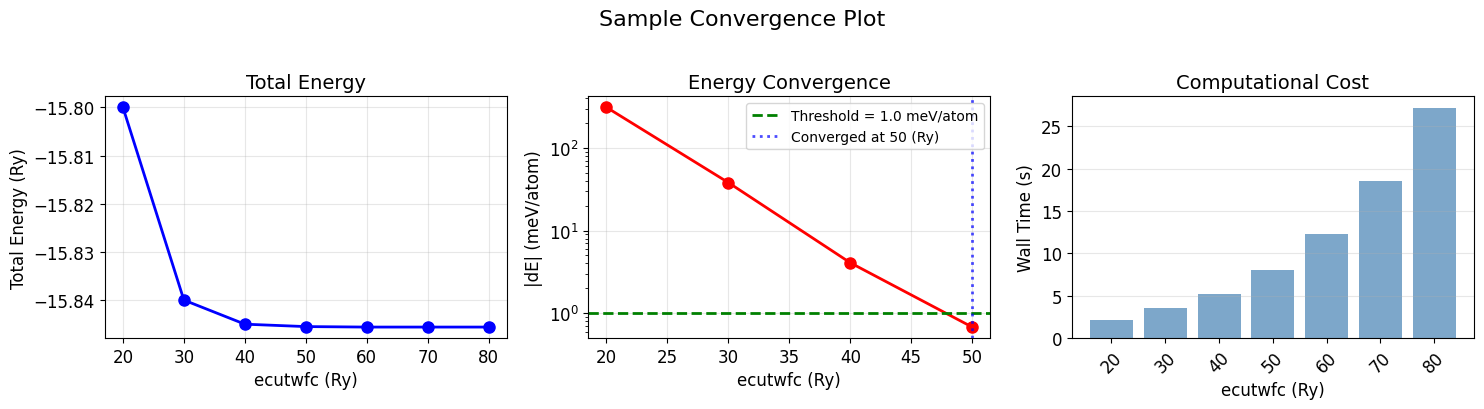

In [6]:
def plot_convergence(
    parameter_values: np.ndarray,
    energies: np.ndarray,
    times: Optional[np.ndarray] = None,
    parameter_name: str = 'Parameter',
    parameter_unit: str = '',
    threshold_mev: float = 1.0,
    n_atoms: int = 2,
    save_path: Optional[Path] = None,
    title: Optional[str] = None
) -> plt.Figure:
    """
    Create comprehensive convergence plots.
    
    Parameters
    ----------
    parameter_values : np.ndarray
        Parameter values tested
    energies : np.ndarray
        Total energies in Ry
    times : np.ndarray, optional
        Calculation times in seconds
    parameter_name : str
        Name of the parameter for labels
    parameter_unit : str
        Unit of the parameter
    threshold_mev : float
        Convergence threshold in meV/atom
    n_atoms : int
        Number of atoms in unit cell
    save_path : Path, optional
        Path to save figure
    title : str, optional
        Custom figure title
    
    Returns
    -------
    matplotlib.figure.Figure
        The created figure
    """
    parameter_values = np.array(parameter_values)
    energies = np.array(energies)
    
    # Calculate energy differences
    E_ref = energies[-1]
    delta_E = (energies - E_ref) * RY_TO_MEV / n_atoms
    
    # Find converged point
    converged_idx = None
    for i, de in enumerate(delta_E):
        if abs(de) <= threshold_mev:
            converged_idx = i
            break
    
    # Create figure
    n_plots = 3 if times is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
    
    unit_str = f" ({parameter_unit})" if parameter_unit else ""
    
    # Plot 1: Absolute energy
    ax1 = axes[0]
    ax1.plot(parameter_values, energies, 'bo-', markersize=8, linewidth=2)
    ax1.set_xlabel(f'{parameter_name}{unit_str}', fontsize=12)
    ax1.set_ylabel('Total Energy (Ry)', fontsize=12)
    ax1.set_title('Total Energy', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Energy convergence (log scale)
    ax2 = axes[1]
    valid_mask = np.abs(delta_E[:-1]) > 1e-10  # Avoid log(0)
    if np.any(valid_mask):
        ax2.semilogy(parameter_values[:-1][valid_mask], np.abs(delta_E[:-1][valid_mask]), 
                     'ro-', markersize=8, linewidth=2)
    ax2.axhline(y=threshold_mev, color='g', linestyle='--', linewidth=2,
                label=f'Threshold = {threshold_mev} meV/atom')
    if converged_idx is not None:
        ax2.axvline(x=parameter_values[converged_idx], color='b', linestyle=':', 
                    alpha=0.7, linewidth=2,
                    label=f'Converged at {parameter_values[converged_idx]}{unit_str}')
    ax2.set_xlabel(f'{parameter_name}{unit_str}', fontsize=12)
    ax2.set_ylabel('|dE| (meV/atom)', fontsize=12)
    ax2.set_title('Energy Convergence', fontsize=14)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Computational cost (if times provided)
    if times is not None:
        ax3 = axes[2]
        ax3.bar(range(len(times)), times, color='steelblue', alpha=0.7)
        ax3.set_xticks(range(len(times)))
        ax3.set_xticklabels([f'{p:.0f}' for p in parameter_values], rotation=45)
        ax3.set_xlabel(f'{parameter_name}{unit_str}', fontsize=12)
        ax3.set_ylabel('Wall Time (s)', fontsize=12)
        ax3.set_title('Computational Cost', fontsize=14)
        ax3.grid(True, alpha=0.3, axis='y')
    
    if title:
        fig.suptitle(title, fontsize=16, y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


# Demonstrate with sample data
sample_params = np.array([20, 30, 40, 50, 60, 70, 80])
sample_energies = np.array([-15.80, -15.84, -15.845, -15.8455, -15.8456, -15.8456, -15.8456])
sample_times = np.array([2.1, 3.5, 5.2, 8.1, 12.3, 18.5, 27.2])

fig = plot_convergence(
    sample_params, sample_energies, sample_times,
    parameter_name='ecutwfc', parameter_unit='Ry',
    threshold_mev=1.0, n_atoms=2,
    title='Sample Convergence Plot'
)
plt.show()

---

## 3. Ecutwfc (Wavefunction Cutoff) Convergence

### Theoretical Background

In plane-wave DFT, wavefunctions are expanded as:

$$\psi_n(\mathbf{r}) = \sum_{\mathbf{G}} c_{n,\mathbf{G}} e^{i(\mathbf{k}+\mathbf{G})\cdot\mathbf{r}}$$

where $\mathbf{G}$ are reciprocal lattice vectors. The cutoff determines which plane waves to include:

$$\frac{\hbar^2}{2m}|\mathbf{k}+\mathbf{G}|^2 < E_{\text{cut}}$$

### Key Points

- **ecutwfc** is the kinetic energy cutoff for wavefunctions (in Ry)
- **ecutrho** is the cutoff for charge density (typically 4x ecutwfc for NC, 8-12x for PAW/USPP)
- Higher cutoff = more plane waves = more accurate but slower
- Convergence is **variational**: energy approaches true value from above

In [7]:
# Define ecutwfc convergence test parameters
ECUTWFC_VALUES = [int(x) for x in range(20, 85, 5)]  # 20, 25, 30, ..., 80 Ry
ECUTRHO_FACTOR = 8  # For PAW/US pseudopotentials (typical)
KPOINTS_FIXED = (6, 6, 6)  # Fixed k-point grid for cutoff tests
CELLDM1_SI = 10.26  # Experimental lattice parameter in Bohr (≈ 5.43 Å)

print("Ecutwfc Convergence Test Parameters")
print("=" * 60)
print(f"ecutwfc range: {ECUTWFC_VALUES[0]} - {ECUTWFC_VALUES[-1]} Ry")
print(f"Step size: 5 Ry")
print(f"Number of tests: {len(ECUTWFC_VALUES)}")
print(f"ecutrho = {ECUTRHO_FACTOR} x ecutwfc")
print(f"K-points (fixed): {KPOINTS_FIXED}")
print(f"Lattice parameter: {CELLDM1_SI} Bohr = {CELLDM1_SI * BOHR_TO_ANGSTROM:.3f} Angstrom")

Ecutwfc Convergence Test Parameters
ecutwfc range: 20 - 80 Ry
Step size: 5 Ry
Number of tests: 13
ecutrho = 8 x ecutwfc
K-points (fixed): (6, 6, 6)
Lattice parameter: 10.26 Bohr = 5.429 Angstrom


In [8]:
# Run ecutwfc convergence tests
ecutwfc_results = []

print("\nRunning ecutwfc convergence tests...")
print("=" * 90)
print(f"{'ecutwfc':<10} {'ecutrho':<10} {'Energy (Ry)':<18} {'dE (meV/atom)':<15} {'Time (s)':<10} {'Status'}")
print("-" * 90)

reference_energy = None

for ecutwfc in ECUTWFC_VALUES:
    ecutrho = ecutwfc * ECUTRHO_FACTOR
    prefix = f'si_ecut{int(ecutwfc)}'
    
    # Generate input
    input_text = generate_scf_input(
        prefix=prefix,
        ecutwfc=ecutwfc,
        ecutrho=ecutrho,
        kpoints=KPOINTS_FIXED,
        pseudo_dir=PSEUDO_DIR,
        celldm1=CELLDM1_SI,
        conv_thr=1.0e-8
    )
    
    # Write input file
    input_file = WORK_DIR / f'{prefix}.in'
    with open(input_file, 'w') as f:
        f.write(input_text)
    
    # Run calculation
    output, elapsed, converged = run_calculation(input_file)
    parsed = parse_output(output)
    
    energy = parsed['energy_ry']
    
    # Calculate energy difference (using highest cutoff as reference, updated iteratively)
    if reference_energy is None and energy is not None:
        reference_energy = energy
    if energy is not None:
        reference_energy = energy  # Update to latest (highest cutoff)
    
    # Store results
    result = {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'energy_ry': energy,
        'time_s': elapsed,
        'converged': converged,
        'total_force': parsed['total_force'],
        'pressure_kbar': parsed['pressure_kbar']
    }
    ecutwfc_results.append(result)
    
    # Print progress
    status = 'OK' if converged else 'FAILED'
    energy_str = f'{energy:.8f}' if energy else 'N/A'
    delta_e_str = 'N/A'
    
    print(f"{ecutwfc:<10.0f} {ecutrho:<10.0f} {energy_str:<18} {delta_e_str:<15} {elapsed:<10.2f} {status}")

print("=" * 90)
print("Ecutwfc convergence tests complete!")

# Save results
results_file = WORK_DIR / 'ecutwfc_convergence_results.json'
with open(results_file, 'w') as f:
    json.dump(ecutwfc_results, f, indent=2)
print(f"\nResults saved to: {results_file}")


Running ecutwfc convergence tests...
ecutwfc    ecutrho    Energy (Ry)        dE (meV/atom)   Time (s)   Status
------------------------------------------------------------------------------------------
Running: pw.x -in si_ecut20.in


  ✗ FAILED (exit code -6)
20         160        N/A                N/A             5.66       FAILED
Running: pw.x -in si_ecut25.in


  ✗ FAILED (exit code -6)
25         200        N/A                N/A             5.01       FAILED
Running: pw.x -in si_ecut30.in


  ✗ FAILED (exit code -6)
30         240        N/A                N/A             5.00       FAILED
Running: pw.x -in si_ecut35.in


  ✗ FAILED (exit code -6)
35         280        N/A                N/A             5.61       FAILED
Running: pw.x -in si_ecut40.in


  ✗ FAILED (exit code -6)
40         320        N/A                N/A             5.00       FAILED
Running: pw.x -in si_ecut45.in


  ✗ FAILED (exit code -6)
45         360        N/A                N/A             5.59       FAILED
Running: pw.x -in si_ecut50.in


  ✗ FAILED (exit code -6)
50         400        N/A                N/A             4.98       FAILED
Running: pw.x -in si_ecut55.in


  ✗ FAILED (exit code -6)
55         440        N/A                N/A             5.00       FAILED
Running: pw.x -in si_ecut60.in


  ✗ FAILED (exit code -6)
60         480        N/A                N/A             5.65       FAILED
Running: pw.x -in si_ecut65.in


  ✗ FAILED (exit code -6)
65         520        N/A                N/A             4.96       FAILED
Running: pw.x -in si_ecut70.in


  ✗ FAILED (exit code -6)
70         560        N/A                N/A             4.99       FAILED
Running: pw.x -in si_ecut75.in


  ✗ FAILED (exit code -6)
75         600        N/A                N/A             5.61       FAILED
Running: pw.x -in si_ecut80.in


  ✗ FAILED (exit code -6)
80         640        N/A                N/A             5.68       FAILED
Ecutwfc convergence tests complete!

Results saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_convergence/ecutwfc_convergence_results.json


In [9]:
# Analyze ecutwfc convergence
converged_results = [r for r in ecutwfc_results if r['converged'] and r['energy_ry'] is not None]

assert len(converged_results) >= 2, "Need at least 2 converged calculations for analysis"

ecutwfc_arr = np.array([r['ecutwfc'] for r in converged_results])
energy_arr = np.array([r['energy_ry'] for r in converged_results])
time_arr = np.array([r['time_s'] for r in converged_results])

# Analyze convergence
conv_analysis = analyze_convergence(
    ecutwfc_arr, energy_arr, 
    threshold_mev_per_atom=1.0, n_atoms=2
)

print("\nEcutwfc Convergence Analysis")
print("=" * 80)
print(f"Reference: ecutwfc = {ecutwfc_arr[-1]} Ry, E = {conv_analysis['reference_energy']:.8f} Ry")
print(f"Threshold: {conv_analysis['threshold_mev_per_atom']} meV/atom")
print(f"\n{'ecutwfc (Ry)':<15} {'Energy (Ry)':<18} {'dE (meV/atom)':<18} {'Time (s)':<12} {'Status'}")
print("-" * 80)

for i in range(len(converged_results)):
    de = conv_analysis['delta_E_meV_per_atom'][i]
    status = 'CONVERGED' if abs(de) <= 1.0 else ''
    print(f"{ecutwfc_arr[i]:<15.0f} {energy_arr[i]:<18.8f} {de:<+18.4f} {time_arr[i]:<12.2f} {status}")

print("=" * 80)

# Report converged value
if conv_analysis['converged_value'] is not None:
    print(f"\n>>> CONVERGED ecutwfc: {conv_analysis['converged_value']} Ry")
    print(f">>> Recommended (with 5 Ry safety margin): {conv_analysis['converged_value'] + 5} Ry")
    ecutwfc_converged = conv_analysis['converged_value']
else:
    print("\n>>> WARNING: No ecutwfc value satisfies convergence criterion!")
    print(">>> Consider testing higher cutoff values.")
    ecutwfc_converged = ecutwfc_arr[-1]  # Use highest tested

AssertionError: Need at least 2 converged calculations for analysis

In [ ]:
# Plot ecutwfc convergence
fig = plot_convergence(
    ecutwfc_arr, energy_arr, time_arr,
    parameter_name='ecutwfc', parameter_unit='Ry',
    threshold_mev=1.0, n_atoms=2,
    save_path=WORK_DIR / 'ecutwfc_convergence.png',
    title='Silicon Wavefunction Cutoff Convergence'
)
plt.show()

---

## 4. K-point Convergence

### Theoretical Background

Many physical quantities require integration over the Brillouin zone:

$$\bar{f} = \frac{1}{V_{BZ}} \int_{BZ} f(\mathbf{k}) d\mathbf{k}$$

This integral is approximated by a discrete sum over k-points:

$$\bar{f} \approx \sum_i w_i f(\mathbf{k}_i)$$

### Monkhorst-Pack Grid

The standard method uses a uniform grid of $n_1 \times n_2 \times n_3$ points. For cubic systems, we typically use $n \times n \times n$.

### Key Points

- Symmetry operations reduce the number of unique k-points
- Metals require denser k-grids than semiconductors/insulators
- K-point density should match cell size (larger cell = fewer k-points needed)

In [ ]:
# Use converged ecutwfc from previous section
ECUTWFC_CONVERGED = ecutwfc_converged + 5  # With safety margin
ECUTRHO_CONVERGED = ECUTWFC_CONVERGED * ECUTRHO_FACTOR

# Define k-point grids to test
KPOINT_GRIDS = [2, 4, 6, 8, 10, 12, 14, 16]

print("K-point Convergence Test Parameters")
print("=" * 60)
print(f"K-grids to test: {KPOINT_GRIDS}")
print(f"ecutwfc (fixed): {ECUTWFC_CONVERGED} Ry")
print(f"ecutrho (fixed): {ECUTRHO_CONVERGED} Ry")

In [ ]:
# Run k-point convergence tests
kpoint_results = []

print("\nRunning k-point convergence tests...")
print("=" * 95)
print(f"{'K-grid':<12} {'Total k-pts':<12} {'Irred. k-pts':<14} {'Energy (Ry)':<18} {'Time (s)':<10} {'Status'}")
print("-" * 95)

for k in KPOINT_GRIDS:
    kpoints = (k, k, k)
    total_kpts = k ** 3
    prefix = f'si_k{k}'
    
    # Generate input
    input_text = generate_scf_input(
        prefix=prefix,
        ecutwfc=ECUTWFC_CONVERGED,
        ecutrho=ECUTRHO_CONVERGED,
        kpoints=kpoints,
        pseudo_dir=PSEUDO_DIR,
        celldm1=CELLDM1_SI,
        conv_thr=1.0e-8
    )
    
    # Write and run
    input_file = WORK_DIR / f'{prefix}.in'
    with open(input_file, 'w') as f:
        f.write(input_text)
    
    output, elapsed, converged = run_calculation(input_file)
    parsed = parse_output(output)
    
    result = {
        'kgrid': k,
        'total_kpts': total_kpts,
        'irreducible_kpts': parsed['nkpts_irreducible'],
        'energy_ry': parsed['energy_ry'],
        'time_s': elapsed,
        'converged': converged,
        'total_force': parsed['total_force'],
        'pressure_kbar': parsed['pressure_kbar']
    }
    kpoint_results.append(result)
    
    status = 'OK' if converged else 'FAILED'
    energy_str = f"{parsed['energy_ry']:.8f}" if parsed['energy_ry'] else 'N/A'
    irr_kpts = parsed['nkpts_irreducible'] if parsed['nkpts_irreducible'] else 'N/A'
    
    print(f"{k}x{k}x{k:<8} {total_kpts:<12} {irr_kpts:<14} {energy_str:<18} {elapsed:<10.2f} {status}")

print("=" * 95)
print("K-point convergence tests complete!")

# Save results
results_file = WORK_DIR / 'kpoint_convergence_results.json'
with open(results_file, 'w') as f:
    json.dump(kpoint_results, f, indent=2)
print(f"\nResults saved to: {results_file}")

In [ ]:
# Analyze k-point convergence
converged_kpt_results = [r for r in kpoint_results if r['converged'] and r['energy_ry'] is not None]

assert len(converged_kpt_results) >= 2, "Need at least 2 converged calculations for analysis"

kgrid_arr = np.array([r['kgrid'] for r in converged_kpt_results])
energy_kpt_arr = np.array([r['energy_ry'] for r in converged_kpt_results])
time_kpt_arr = np.array([r['time_s'] for r in converged_kpt_results])
nkpts_irr_arr = np.array([r['irreducible_kpts'] for r in converged_kpt_results])

# Analyze convergence
kpt_conv_analysis = analyze_convergence(
    kgrid_arr, energy_kpt_arr,
    threshold_mev_per_atom=1.0, n_atoms=2
)

print("\nK-point Convergence Analysis")
print("=" * 90)
print(f"Reference: {kgrid_arr[-1]}x{kgrid_arr[-1]}x{kgrid_arr[-1]} grid, E = {kpt_conv_analysis['reference_energy']:.8f} Ry")
print(f"\n{'K-grid':<12} {'Irred. k-pts':<14} {'Energy (Ry)':<18} {'dE (meV/atom)':<18} {'Status'}")
print("-" * 90)

for i in range(len(converged_kpt_results)):
    k = kgrid_arr[i]
    de = kpt_conv_analysis['delta_E_meV_per_atom'][i]
    status = 'CONVERGED' if abs(de) <= 1.0 else ''
    print(f"{k}x{k}x{k:<8} {nkpts_irr_arr[i]:<14} {energy_kpt_arr[i]:<18.8f} {de:<+18.4f} {status}")

print("=" * 90)

if kpt_conv_analysis['converged_value'] is not None:
    kgrid_converged = int(kpt_conv_analysis['converged_value'])
    print(f"\n>>> CONVERGED k-grid: {kgrid_converged}x{kgrid_converged}x{kgrid_converged}")
    print(f">>> Recommended (with safety margin): {kgrid_converged+2}x{kgrid_converged+2}x{kgrid_converged+2}")
else:
    print("\n>>> WARNING: No k-grid satisfies convergence criterion!")
    kgrid_converged = int(kgrid_arr[-1])

In [ ]:
# Plot k-point convergence
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

kgrid_labels = [f'{k}x{k}x{k}' for k in kgrid_arr]
x_pos = np.arange(len(kgrid_arr))

# Energy vs k-grid
ax1 = axes[0, 0]
ax1.plot(x_pos, energy_kpt_arr, 'bo-', markersize=10, linewidth=2)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(kgrid_labels, rotation=45)
ax1.set_xlabel('K-point Grid', fontsize=12)
ax1.set_ylabel('Total Energy (Ry)', fontsize=12)
ax1.set_title('Total Energy vs K-points', fontsize=14)
ax1.grid(True, alpha=0.3)

# Convergence plot
ax2 = axes[0, 1]
delta_E_kpt = kpt_conv_analysis['delta_E_meV_per_atom']
valid_mask = np.abs(delta_E_kpt[:-1]) > 1e-10
if np.any(valid_mask):
    ax2.semilogy(x_pos[:-1][valid_mask], np.abs(delta_E_kpt[:-1][valid_mask]), 'ro-', markersize=10, linewidth=2)
ax2.axhline(y=1.0, color='g', linestyle='--', linewidth=2, label='1 meV/atom threshold')
ax2.set_xticks(x_pos[:-1])
ax2.set_xticklabels(kgrid_labels[:-1], rotation=45)
ax2.set_xlabel('K-point Grid', fontsize=12)
ax2.set_ylabel('|dE| (meV/atom)', fontsize=12)
ax2.set_title('K-point Convergence', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Timing
ax3 = axes[1, 0]
ax3.bar(x_pos, time_kpt_arr, color='steelblue', alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(kgrid_labels, rotation=45)
ax3.set_xlabel('K-point Grid', fontsize=12)
ax3.set_ylabel('Wall Time (s)', fontsize=12)
ax3.set_title('Computational Cost', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')

# Symmetry reduction
ax4 = axes[1, 1]
total_kpts_arr = kgrid_arr ** 3
ax4.bar(x_pos - 0.15, total_kpts_arr, width=0.3, label='Total k-points', color='lightcoral', alpha=0.7)
ax4.bar(x_pos + 0.15, nkpts_irr_arr, width=0.3, label='Irreducible k-points', color='steelblue', alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(kgrid_labels, rotation=45)
ax4.set_xlabel('K-point Grid', fontsize=12)
ax4.set_ylabel('Number of K-points', fontsize=12)
ax4.set_title('Symmetry Reduction', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(WORK_DIR / 'kpoint_convergence.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {WORK_DIR / 'kpoint_convergence.png'}")

---

## 5. Smearing Width Convergence (For Metals)

### Why Smearing Matters for Metals

Metals have a Fermi surface where electronic states are partially occupied. This creates numerical problems:

1. Sharp discontinuity at Fermi level makes k-point integration difficult
2. Fractional occupations cause SCF convergence issues

**Solution**: Smear the Fermi surface by broadening occupation numbers.

### Types of Smearing

| Type | QE keyword | Description |
|------|------------|-------------|
| Gaussian | `gaussian` | Simple Gaussian broadening |
| Methfessel-Paxton | `mp` | Higher-order corrections |
| Marzari-Vanderbilt | `mv` or `cold` | Optimized for forces |
| Fermi-Dirac | `fd` | Physical thermal occupation |

### The Convergence Challenge

- Large degauss: Easy convergence but introduces error
- Small degauss: Accurate but hard to converge, needs many k-points
- Goal: Find the smallest degauss that converges with your k-mesh

**Note**: Silicon is a semiconductor, so smearing is less critical. We demonstrate the concept here, but this is essential for metals like Al, Cu, Fe, etc.

In [ ]:
# Smearing convergence test parameters
DEGAUSS_VALUES = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]  # in Ry

print("Smearing Width Convergence Test Parameters")
print("=" * 60)
print(f"degauss range: {DEGAUSS_VALUES[0]} - {DEGAUSS_VALUES[-1]} Ry")
print(f"degauss in meV: {[round(d * RY_TO_MEV, 1) for d in DEGAUSS_VALUES]} meV")
print(f"ecutwfc: {ECUTWFC_CONVERGED} Ry")
print(f"K-grid: {kgrid_converged+2}x{kgrid_converged+2}x{kgrid_converged+2}")
print(f"\nNote: For semiconductors like Si, smearing has minimal effect.")
print("      This test is critical for metallic systems.")

In [ ]:
# Run smearing convergence tests
smearing_results = []
kgrid_for_smearing = kgrid_converged + 2

print("\nRunning smearing convergence tests...")
print("=" * 85)
print(f"{'degauss (Ry)':<15} {'degauss (meV)':<15} {'Energy (Ry)':<18} {'Time (s)':<10} {'Status'}")
print("-" * 85)

for degauss in DEGAUSS_VALUES:
    prefix = f'si_smear{int(degauss*1000)}'
    
    input_text = generate_scf_input(
        prefix=prefix,
        ecutwfc=ECUTWFC_CONVERGED,
        ecutrho=ECUTRHO_CONVERGED,
        kpoints=(kgrid_for_smearing, kgrid_for_smearing, kgrid_for_smearing),
        pseudo_dir=PSEUDO_DIR,
        celldm1=CELLDM1_SI,
        conv_thr=1.0e-8,
        degauss=degauss,
        smearing='cold'
    )
    
    input_file = WORK_DIR / f'{prefix}.in'
    with open(input_file, 'w') as f:
        f.write(input_text)
    
    output, elapsed, converged = run_calculation(input_file)
    parsed = parse_output(output)
    
    result = {
        'degauss_ry': degauss,
        'degauss_mev': degauss * RY_TO_MEV / 1000,
        'energy_ry': parsed['energy_ry'],
        'time_s': elapsed,
        'converged': converged
    }
    smearing_results.append(result)
    
    status = 'OK' if converged else 'FAILED'
    energy_str = f"{parsed['energy_ry']:.8f}" if parsed['energy_ry'] else 'N/A'
    degauss_mev = degauss * RY_TO_MEV / 1000
    
    print(f"{degauss:<15.4f} {degauss_mev:<15.1f} {energy_str:<18} {elapsed:<10.2f} {status}")

print("=" * 85)
print("Smearing convergence tests complete!")

# Save results
results_file = WORK_DIR / 'smearing_convergence_results.json'
with open(results_file, 'w') as f:
    json.dump(smearing_results, f, indent=2)
print(f"\nResults saved to: {results_file}")

---

## 7. Functional Comparison: PBE vs LDA vs PBEsol

### Why Compare Functionals?

Different exchange-correlation functionals give different results! Students should see this directly.

| Functional | Lattice Constants | Band Gaps | Best For |
|------------|------------------|-----------|----------|
| **LDA** | Underestimates (~2%) | Underestimates | Metals, old literature comparison |
| **PBE** | Overestimates (~1-2%) | Underestimates | General purpose |
| **PBEsol** | More accurate | Underestimates | Solids, lattice properties |

### Typical Errors for Silicon

| Property | Experiment | LDA | PBE | PBEsol |
|----------|------------|-----|-----|--------|
| a (Å) | 5.431 | 5.40 | 5.47 | 5.44 |
| B (GPa) | 99 | 97 | 89 | 94 |
| Eg (eV) | 1.17 | 0.5 | 0.6 | 0.5 |

In [ ]:
# =============================================================================
# FUNCTIONAL COMPARISON: See how PBE, LDA, PBEsol differ!
# =============================================================================
# This is a KEY learning experience - students should see that functional
# choice matters and understand the systematic differences.
# =============================================================================

def run_functional_comparison(atoms, ecutwfc, kpts=(8,8,8)):
    """
    Run SCF with different functionals and compare results.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure
    ecutwfc : float
        Cutoff energy
    kpts : tuple
        K-point mesh
    
    Returns
    -------
    dict : Results for each functional
    """
    functionals = ['PBE', 'LDA', 'PBEsol']
    results = {}
    
    print("=" * 70)
    print("FUNCTIONAL COMPARISON")
    print("=" * 70)
    print(f"Material: {atoms.get_chemical_formula()}")
    print(f"ecutwfc: {ecutwfc} Ry, kpts: {kpts}")
    print("=" * 70)
    
    for func in functionals:
        print(f"\n--- Running {func} ---")
        
        # Setup pseudopotentials for this functional
        elements = list(set(atoms.get_chemical_symbols()))
        pp_files = setup_pseudopotentials(elements, functional=func)
        pseudo_dir = get_pseudo_dir(func)
        
        pseudopotentials = {el: get_pseudopotential_filename(el, func) 
                          for el in elements}
        
        prefix = f'compare_{func.lower()}'
        input_file = WORK_DIR / f'{prefix}.in'
        
        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix,
                'outdir': './tmp',
                'pseudo_dir': str(pseudo_dir),
                'tprnfor': True,
                'tstress': True,
            },
            'system': {
                'ecutwfc': ecutwfc,
                'ecutrho': ecutwfc * 8,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }
        
        write_espresso_in(input_file, atoms, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=kpts)
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
        
        # Parse results
        energy = None
        pressure = None
        for line in output.split('\n'):
            if '!' in line and 'total energy' in line:
                match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
                if match:
                    energy = float(match.group(1)) * RY_TO_EV
            if 'P=' in line:
                match = re.search(r'P=\s*([-\d.]+)', line)
                if match:
                    pressure = float(match.group(1))
        
        results[func] = {
            'energy_eV': energy,
            'energy_eV_per_atom': energy / len(atoms) if energy else None,
            'pressure_kbar': pressure,
            'converged': converged,
            'elapsed_s': elapsed,
        }
        
        if energy:
            print(f"  Energy: {energy:.6f} eV ({energy/len(atoms):.6f} eV/atom)")
            if pressure:
                print(f"  Pressure: {pressure:.2f} kbar")
    
    # Print comparison table
    print("\n" + "=" * 70)
    print("COMPARISON TABLE")
    print("=" * 70)
    print(f"{'Functional':<12} {'E (eV/atom)':<15} {'P (kbar)':<12} {'Time (s)':<10}")
    print("-" * 50)
    
    ref_energy = results['PBE']['energy_eV_per_atom']
    for func in functionals:
        r = results[func]
        e = r['energy_eV_per_atom']
        p = r['pressure_kbar']
        t = r['elapsed_s']
        
        if e and ref_energy:
            delta = (e - ref_energy) * 1000  # meV
            print(f"{func:<12} {e:<15.6f} {p:<12.2f} {t:<10.1f} (ΔE={delta:+.1f} meV vs PBE)")
        else:
            print(f"{func:<12} {'FAILED':<15}")
    
    print("=" * 70)
    print("\nKey observations:")
    print("- LDA typically gives LOWER (more negative) energies than PBE")
    print("- LDA underestimates lattice constants → positive pressure at exp. volume")
    print("- PBE overestimates lattice constants → negative pressure at exp. volume")
    print("- PBEsol is intermediate, often best for lattice properties")
    
    return results


# To run functional comparison (uncomment):
# func_results = run_functional_comparison(atoms, ecutwfc_sssp)

print("Functional comparison function defined.")
print("\nTo compare functionals: func_results = run_functional_comparison(atoms, ecutwfc)")

In [ ]:
# Analyze smearing convergence
converged_smear_results = [r for r in smearing_results if r['converged'] and r['energy_ry'] is not None]

if len(converged_smear_results) >= 2:
    degauss_arr = np.array([r['degauss_ry'] for r in converged_smear_results])
    energy_smear_arr = np.array([r['energy_ry'] for r in converged_smear_results])
    
    # Reference: smallest degauss (most accurate)
    E_ref_smear = energy_smear_arr[0]
    delta_E_smear = (energy_smear_arr - E_ref_smear) * RY_TO_MEV / 2  # meV/atom
    
    print("\nSmearing Convergence Analysis")
    print("=" * 70)
    print(f"Reference: degauss = {degauss_arr[0]*1000:.1f} mRy, E = {E_ref_smear:.8f} Ry")
    print(f"\n{'degauss (mRy)':<15} {'Energy (Ry)':<18} {'dE (meV/atom)':<18}")
    print("-" * 70)
    
    for i in range(len(converged_smear_results)):
        print(f"{degauss_arr[i]*1000:<15.1f} {energy_smear_arr[i]:<18.8f} {delta_E_smear[i]:<+18.4f}")
    
    print("=" * 70)
    print("\n>>> For semiconductors, smearing effects are typically < 0.1 meV/atom")
    print(">>> For metals, use the smallest degauss that gives stable SCF convergence")
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(degauss_arr * 1000, delta_E_smear, 'go-', markersize=10, linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 meV/atom')
    ax.axhline(y=-1, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('degauss (mRy)', fontsize=12)
    ax.set_ylabel('dE (meV/atom)', fontsize=12)
    ax.set_title('Smearing Width Convergence', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(WORK_DIR / 'smearing_convergence.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough converged smearing calculations for analysis.")

---

## 6. Combined Convergence Analysis (2D Grid)

In production work, we often need to verify that our chosen parameters are truly converged with respect to **both** ecutwfc and k-points simultaneously.

This 2D convergence table helps identify the optimal parameter set.

In [ ]:
# Define 2D convergence grid (reduced for efficiency)
ECUTWFC_2D = [30, 40, 50, 60]
KGRID_2D = [4, 6, 8, 10]

print("2D Convergence Grid Parameters")
print("=" * 50)
print(f"ecutwfc values: {ECUTWFC_2D} Ry")
print(f"K-grids: {KGRID_2D}")
print(f"Total calculations: {len(ECUTWFC_2D) * len(KGRID_2D)}")

In [ ]:
# Run 2D convergence tests
combined_results = []
energy_grid = np.zeros((len(ECUTWFC_2D), len(KGRID_2D)))
time_grid = np.zeros((len(ECUTWFC_2D), len(KGRID_2D)))

print("\nRunning 2D convergence grid...")
print("=" * 80)

for i, ecutwfc in enumerate(ECUTWFC_2D):
    for j, kgrid in enumerate(KGRID_2D):
        prefix = f'si_e{int(ecutwfc)}_k{kgrid}'
        
        input_text = generate_scf_input(
            prefix=prefix,
            ecutwfc=ecutwfc,
            ecutrho=ecutwfc * ECUTRHO_FACTOR,
            kpoints=(kgrid, kgrid, kgrid),
            pseudo_dir=PSEUDO_DIR,
            celldm1=CELLDM1_SI
        )
        
        input_file = WORK_DIR / f'{prefix}.in'
        with open(input_file, 'w') as f:
            f.write(input_text)
        
        output, elapsed, converged = run_calculation(input_file)
        parsed = parse_output(output)
        
        energy = parsed['energy_ry'] if parsed['energy_ry'] else np.nan
        energy_grid[i, j] = energy
        time_grid[i, j] = elapsed
        
        combined_results.append({
            'ecutwfc': ecutwfc,
            'kgrid': kgrid,
            'energy_ry': energy,
            'time_s': elapsed,
            'converged': converged
        })
        
        status = 'OK' if converged else 'FAILED'
        energy_str = f"{energy:.8f}" if not np.isnan(energy) else 'N/A'
        print(f"ecutwfc={ecutwfc}, k={kgrid}x{kgrid}x{kgrid}: E={energy_str}, t={elapsed:.1f}s [{status}]")

print("=" * 80)
print("2D convergence grid complete!")

# Save results
with open(WORK_DIR / 'combined_convergence_results.json', 'w') as f:
    json.dump(combined_results, f, indent=2)

In [ ]:
# Create 2D convergence table and heatmap
E_ref_2d = energy_grid[-1, -1]  # Most converged point
delta_E_grid = (energy_grid - E_ref_2d) * RY_TO_MEV / 2  # meV/atom

# Print table
print("\n2D Convergence Table (dE in meV/atom)")
print("=" * 60)
print(f"Reference: ecutwfc={ECUTWFC_2D[-1]} Ry, k={KGRID_2D[-1]}x{KGRID_2D[-1]}x{KGRID_2D[-1]}")
print(f"Reference energy: {E_ref_2d:.8f} Ry\n")

# Header
header = f"{'ecutwfc (Ry)':<15}"
for k in KGRID_2D:
    header += f"k={k:<10}"
print(header)
print("-" * 60)

for i, ecutwfc in enumerate(ECUTWFC_2D):
    row = f"{ecutwfc:<15}"
    for j in range(len(KGRID_2D)):
        de = delta_E_grid[i, j]
        if np.isnan(de):
            row += f"{'N/A':<14}"
        else:
            marker = '*' if abs(de) < 1.0 else ' '
            row += f"{de:+.4f}{marker:<8}"
    print(row)

print("-" * 60)
print("* indicates converged (|dE| < 1 meV/atom)")

In [ ]:
# Plot 2D convergence heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy convergence heatmap
ax1 = axes[0]
im1 = ax1.imshow(np.abs(delta_E_grid), cmap='RdYlGn_r', aspect='auto',
                  vmin=0, vmax=max(5, np.nanmax(np.abs(delta_E_grid))))
ax1.set_xticks(range(len(KGRID_2D)))
ax1.set_xticklabels([f'{k}x{k}x{k}' for k in KGRID_2D])
ax1.set_yticks(range(len(ECUTWFC_2D)))
ax1.set_yticklabels(ECUTWFC_2D)
ax1.set_xlabel('K-point Grid', fontsize=12)
ax1.set_ylabel('ecutwfc (Ry)', fontsize=12)
ax1.set_title('Energy Convergence |dE| (meV/atom)', fontsize=14)

# Add text annotations
for i in range(len(ECUTWFC_2D)):
    for j in range(len(KGRID_2D)):
        de = delta_E_grid[i, j]
        if not np.isnan(de):
            text_color = 'white' if abs(de) > 2.5 else 'black'
            ax1.text(j, i, f'{abs(de):.2f}', ha='center', va='center', 
                     color=text_color, fontsize=10, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('|dE| (meV/atom)', fontsize=10)

# Timing heatmap
ax2 = axes[1]
im2 = ax2.imshow(time_grid, cmap='Blues', aspect='auto')
ax2.set_xticks(range(len(KGRID_2D)))
ax2.set_xticklabels([f'{k}x{k}x{k}' for k in KGRID_2D])
ax2.set_yticks(range(len(ECUTWFC_2D)))
ax2.set_yticklabels(ECUTWFC_2D)
ax2.set_xlabel('K-point Grid', fontsize=12)
ax2.set_ylabel('ecutwfc (Ry)', fontsize=12)
ax2.set_title('Computational Cost (seconds)', fontsize=14)

for i in range(len(ECUTWFC_2D)):
    for j in range(len(KGRID_2D)):
        ax2.text(j, i, f'{time_grid[i,j]:.1f}', ha='center', va='center', 
                 color='black', fontsize=10)

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Time (s)', fontsize=10)

plt.tight_layout()
plt.savefig(WORK_DIR / 'combined_convergence_2d.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {WORK_DIR / 'combined_convergence_2d.png'}")

---

## 7. Force and Stress Convergence

### Why Forces and Stresses Need Tighter Convergence

Forces and stresses are **derivatives** of the energy:

$$F_i = -\frac{\partial E}{\partial R_i}$$

$$\sigma_{ij} = \frac{1}{V}\frac{\partial E}{\partial \epsilon_{ij}}$$

As derivatives, they are more sensitive to numerical errors than the energy itself.

### Typical Requirements

| Quantity | Energy Convergence | Force/Stress Convergence |
|----------|-------------------|-------------------------|
| Energy differences | 1 meV/atom | - |
| Geometry optimization | 1 meV/atom | < 10 meV/Angstrom |
| Phonon calculations | 0.1 meV/atom | < 1 meV/Angstrom |
| Elastic constants | 0.1 meV/atom | < 0.5 kbar |

In [ ]:
# Analyze force and stress convergence from previous runs
print("Force and Stress Convergence Analysis")
print("=" * 70)

# Analyze ecutwfc runs
print("\nEcutwfc dependence of forces and stress:")
print("-" * 70)
print(f"{'ecutwfc (Ry)':<15} {'Total Force (Ry/Bohr)':<22} {'Pressure (kbar)':<18}")
print("-" * 70)

for result in ecutwfc_results:
    if result['converged']:
        force_str = f"{result['total_force']:.6f}" if result['total_force'] is not None else 'N/A'
        press_str = f"{result['pressure_kbar']:.2f}" if result['pressure_kbar'] is not None else 'N/A'
        print(f"{result['ecutwfc']:<15.0f} {force_str:<22} {press_str:<18}")

print("\nK-point dependence of forces and stress:")
print("-" * 70)
print(f"{'K-grid':<15} {'Total Force (Ry/Bohr)':<22} {'Pressure (kbar)':<18}")
print("-" * 70)

for result in kpoint_results:
    if result['converged']:
        k = result['kgrid']
        force_str = f"{result['total_force']:.6f}" if result['total_force'] is not None else 'N/A'
        press_str = f"{result['pressure_kbar']:.2f}" if result['pressure_kbar'] is not None else 'N/A'
        print(f"{k}x{k}x{k:<11} {force_str:<22} {press_str:<18}")

print("\n" + "=" * 70)
print("Notes on force/stress convergence:")
print("- For Si in the diamond structure, forces should be exactly zero by symmetry")
print("- Non-zero forces indicate numerical noise (should be < 10^-4 Ry/Bohr)")
print("- Pressure depends on lattice parameter; at equilibrium it should be ~0")
print("- For cell optimization, ensure stress converges to < 0.5 kbar")

---

## 8. Complete Silicon Convergence Study Summary

Let's compile all our findings into a comprehensive summary.

In [ ]:
# Create comprehensive summary
print("\n" + "="*80)
print("            SILICON CONVERGENCE STUDY - COMPLETE SUMMARY")
print("="*80)

print("\n1. SYSTEM INFORMATION")
print("-"*60)
print(f"   Material: Silicon (diamond structure)")
print(f"   Atoms per cell: 2")
print(f"   Lattice parameter: {CELLDM1_SI} Bohr = {CELLDM1_SI * BOHR_TO_ANGSTROM:.4f} Angstrom")
print(f"   Pseudopotential: Si.upf (PAW)")

print("\n2. CONVERGENCE CRITERIA USED")
print("-"*60)
print(f"   Energy threshold: 1 meV/atom")
print(f"   Force threshold: 10^-4 Ry/Bohr")
print(f"   Stress threshold: 0.5 kbar")

print("\n3. ECUTWFC CONVERGENCE RESULTS")
print("-"*60)
if conv_analysis['converged_value'] is not None:
    print(f"   Converged ecutwfc: {conv_analysis['converged_value']} Ry")
    print(f"   Recommended ecutwfc: {conv_analysis['converged_value'] + 5} Ry (with safety margin)")
else:
    print(f"   WARNING: Convergence not achieved in tested range")
print(f"   ecutrho factor: {ECUTRHO_FACTOR}x ecutwfc")

print("\n4. K-POINT CONVERGENCE RESULTS")
print("-"*60)
if kpt_conv_analysis['converged_value'] is not None:
    k = int(kpt_conv_analysis['converged_value'])
    print(f"   Converged k-grid: {k}x{k}x{k}")
    print(f"   Recommended k-grid: {k+2}x{k+2}x{k+2} (with safety margin)")
else:
    print(f"   WARNING: Convergence not achieved in tested range")

print("\n5. RECOMMENDED PRODUCTION PARAMETERS")
print("-"*60)
recommended_ecutwfc = conv_analysis['converged_value'] + 5 if conv_analysis['converged_value'] else 50
recommended_kgrid = kgrid_converged + 2
print(f"   ecutwfc = {recommended_ecutwfc} Ry")
print(f"   ecutrho = {recommended_ecutwfc * ECUTRHO_FACTOR} Ry")
print(f"   K-points = {recommended_kgrid}x{recommended_kgrid}x{recommended_kgrid}")
print(f"   degauss = 0.01 Ry (for smearing)")

print("\n" + "="*80)

---

## 9. Save Converged Parameters for Subsequent Calculations

In [ ]:
# Save converged parameters to JSON file
converged_parameters = {
    'material': 'Silicon',
    'structure': 'diamond',
    'n_atoms': 2,
    'lattice_parameter_bohr': CELLDM1_SI,
    'lattice_parameter_angstrom': CELLDM1_SI * BOHR_TO_ANGSTROM,
    'pseudopotential': 'Si.upf',
    'convergence_criteria': {
        'energy_mev_per_atom': 1.0,
        'force_ry_per_bohr': 1e-4,
        'stress_kbar': 0.5
    },
    'ecutwfc': {
        'converged': float(conv_analysis['converged_value']) if conv_analysis['converged_value'] else None,
        'recommended': float(recommended_ecutwfc),
        'unit': 'Ry'
    },
    'ecutrho': {
        'factor': ECUTRHO_FACTOR,
        'recommended': float(recommended_ecutwfc * ECUTRHO_FACTOR),
        'unit': 'Ry'
    },
    'kpoints': {
        'converged': int(kgrid_converged) if kpt_conv_analysis['converged_value'] else None,
        'recommended': int(recommended_kgrid),
        'grid': [int(recommended_kgrid)] * 3
    },
    'smearing': {
        'type': 'cold',
        'degauss_ry': 0.01
    },
    'scf': {
        'conv_thr': 1.0e-8,
        'mixing_beta': 0.7
    },
    'metadata': {
        'date': time.strftime('%Y-%m-%d'),
        'notebook': '04_Convergence_Testing.ipynb'
    }
}

# Save to file
params_file = WORKSHOP_ROOT / 'converged_parameters.json'
with open(params_file, 'w') as f:
    json.dump(converged_parameters, f, indent=2)

print("Converged parameters saved to:")
print(f"  {params_file}")
print("\nFile contents:")
print(json.dumps(converged_parameters, indent=2))

In [ ]:
# Demonstrate loading and using converged parameters
def load_converged_parameters(filepath: Path) -> Dict:
    """
    Load converged parameters from JSON file.
    
    Parameters
    ----------
    filepath : Path
        Path to converged_parameters.json
    
    Returns
    -------
    dict
        Dictionary with all converged parameters
    """
    with open(filepath, 'r') as f:
        params = json.load(f)
    return params


def generate_production_input(params: Dict, prefix: str, pseudo_dir: Path) -> str:
    """
    Generate a production-quality SCF input using converged parameters.
    
    Parameters
    ----------
    params : dict
        Loaded converged parameters
    prefix : str
        Job prefix
    pseudo_dir : Path
        Pseudopotential directory
    
    Returns
    -------
    str
        Complete input file content
    """
    kgrid = params['kpoints']['grid']
    
    return generate_scf_input(
        prefix=prefix,
        ecutwfc=params['ecutwfc']['recommended'],
        ecutrho=params['ecutrho']['recommended'],
        kpoints=tuple(kgrid),
        pseudo_dir=pseudo_dir,
        celldm1=params['lattice_parameter_bohr'],
        conv_thr=params['scf']['conv_thr'],
        degauss=params['smearing']['degauss_ry'],
        smearing=params['smearing']['type']
    )


# Demonstrate usage
loaded_params = load_converged_parameters(params_file)
production_input = generate_production_input(loaded_params, 'si_production', PSEUDO_DIR)

print("Production-Quality Input File:")
print("=" * 60)
print(production_input)

---

## 10. Key Takeaways

### Summary of This Notebook

1. **Convergence testing is mandatory** - Never skip this step
2. **Test systematically** - One parameter at a time, then verify with 2D grid
3. **Use appropriate thresholds** - 1 meV/atom for most properties, tighter for forces/phonons
4. **Document your tests** - Save results for reproducibility
5. **Add safety margins** - Production calculations should use slightly higher values

### Common Mistakes to Avoid

| Mistake | Why It's Bad | Solution |
|---------|-------------|----------|
| Using literature values blindly | Different pseudopotentials need different cutoffs | Always test yourself |
| Converging ecutwfc but not k-points | Both affect accuracy | Test both, ideally 2D grid |
| Using the same parameters for all properties | Forces need tighter convergence | Adjust for property of interest |
| Not saving convergence data | Can't reproduce or verify | Save to JSON files |

### Parameter Guidelines

| Pseudopotential Type | Typical ecutwfc | ecutrho Factor |
|---------------------|-----------------|----------------|
| Norm-conserving | 60-100 Ry | 4x |
| Ultrasoft | 30-50 Ry | 8-10x |
| PAW | 30-60 Ry | 8-12x |

### Next Steps

With converged parameters in hand, you can now proceed to:
- Lattice parameter optimization
- Band structure calculations
- Density of states
- Phonon calculations
- And any other property calculations

**Always load and use your converged_parameters.json for production calculations!**